# Fraud Detection EDA

In [1]:
import numpy as np
import pandas as pd
from summarytools import dfSummary
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
df = pd.read_csv("tr_fincrime_train.csv")

In [3]:
df.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [23]:
# a general overview of the dataset
# dfSummary(df)

In [128]:
# %%capture
# df.columns, df.describe(), df.info(), df.isna().sum(), df.duplicated().sum(), df.nunique()

## Visualisation

### Fraud by Location

In [4]:
from data_visualisation.fraud_by_loc import FraudMapApp
fraud_transactions = df[df["is_fraud"] == 1]
fraud_map = FraudMapApp(fraud_transactions).run()

### Fraud by Gender

In [5]:
# One-hot encode the gender column
df = pd.get_dummies(df, columns=['gender'], drop_first=True)

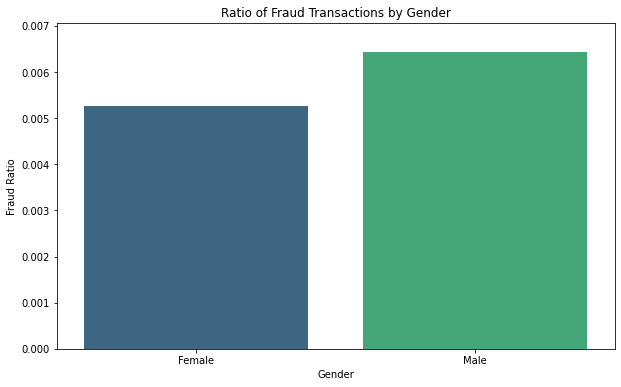

In [6]:
# Calculate the fraud ratio by gender
fraud_ratio_by_gender = df.groupby("gender_M")["is_fraud"].mean().reset_index()

# Plot the fraud ratio by gender
plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_ratio_by_gender, x="gender_M", y="is_fraud", palette="viridis")
plt.title("Ratio of Fraud Transactions by Gender")
plt.xticks(ticks=[0, 1], labels=["Female", "Male"])
plt.xlabel("Gender")
plt.ylabel("Fraud Ratio")
plt.ylim(0, fraud_ratio_by_gender["is_fraud"].max() * 1.1)
plt.show()

### Fraud by Job

I divide the jobs into 11 categories with the help from LLMs: 
1. Healthcare & Medical
2. Engineering & Technology
3. Finance, Banking & Insurance
4. Education & Research
5. Creative Arts, Design & Media
6. Legal & Public Sector
7. Business, Management & Consultancy
8. Science & Research
9. Logistics, Transport & Supply Chain
10. Construction & Property
11. Hospitality, Tourism & Leisure

In [7]:
from data_visualisation.map_job import categorize_and_encode_jobs
import json

# Load from a JSON file
with open('data_visualisation/jobs_by_category.json', 'r') as f:
    job_categories = json.load(f)

In [8]:
df = categorize_and_encode_jobs(df, "job", job_categories)

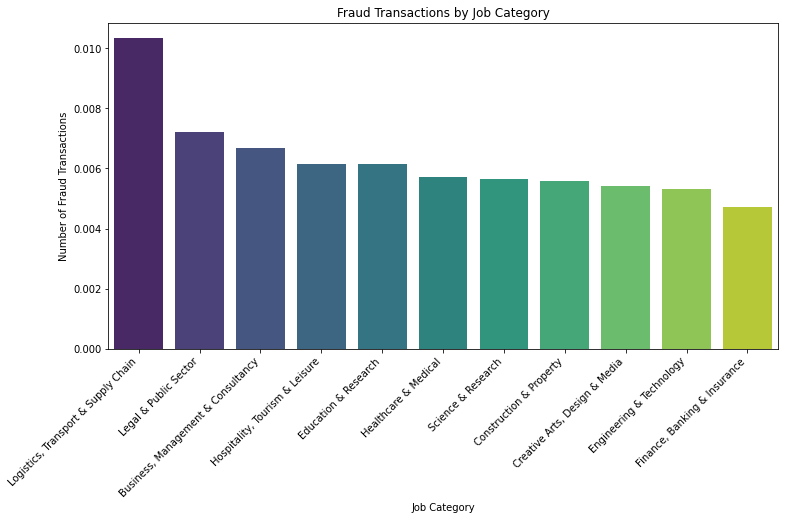

In [9]:
fraud_by_job_category = df.groupby("job_category")["is_fraud"].mean().reset_index(name="fraud_count")
fraud_by_job_category = fraud_by_job_category.sort_values(by="fraud_count", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_job_category, x="job_category", y="fraud_count", palette="viridis")
plt.title("Fraud Transactions by Job Category")
plt.xlabel("Job Category")
plt.ylabel("Number of Fraud Transactions")
plt.xticks(rotation=45, ha="right")
plt.show()

### Fraud by Category

In [10]:
df.category.unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

In [11]:
from data_visualisation.map_job import encode_category
df = encode_category(df, "category", "category_encoded")

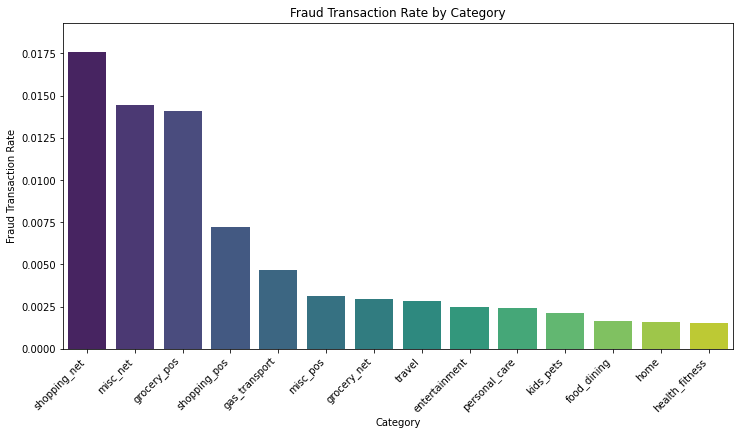

In [12]:
# Calculate the fraud transaction rate by category
fraud_rate_by_category = df.groupby("category")["is_fraud"].mean().reset_index()
fraud_rate_by_category = fraud_rate_by_category.sort_values(by="is_fraud", ascending=False)
# Plot the fraud transaction rate by category
plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_rate_by_category, x="category", y="is_fraud", palette="viridis")
plt.title("Fraud Transaction Rate by Category")
plt.xlabel("Category")
plt.ylabel("Fraud Transaction Rate")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, fraud_rate_by_category["is_fraud"].max() * 1.1)
plt.show()

online(CNP) frauds are majority.

## Data Preprocessing and Feature Engineering 

### 1. Age Group 

calculate the age of the credicard holder when the transaction was made since the trascation history has a duration of 536 days and divide them into age groups. The choice of group boundary and bandwidth could be decided in several ways. Either be looking at the quantile of the age distribution or heuristically from domain knowledge or look at the 'risk' of being frauded.

In [13]:
from datetime import datetime

df["dob"] = pd.to_datetime(df["dob"], errors="coerce")
df["trans_date_trans_time"] = pd.to_datetime(
    df["trans_date_trans_time"], errors="coerce"
)
df["age"] = (df["trans_date_trans_time"] - df["dob"]).dt.days // 365

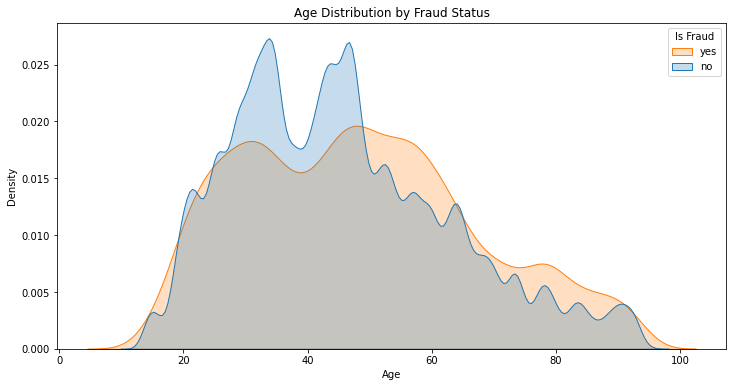

In [14]:
# Set the plot size
plt.figure(figsize=(12, 6))

# Density plot for age, separated by fraud status
sns.kdeplot(data=df, x="age", hue="is_fraud", common_norm=False, fill=True)
plt.title("Age Distribution by Fraud Status")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title="Is Fraud", labels=["yes", "no"])

plt.show()

The average retire age in the US is around 63-65 (65+) and considering average poeple leave university around 25. More than 82% of adults(25-54) had a credit card as of 2023. Financially, most people hit their career peak in their late 40s, 50s. Considering all these factors combined with the plot above, I decided to group the card holders in 4 age groups: Under 25, 25-45, 45-65, 65+.

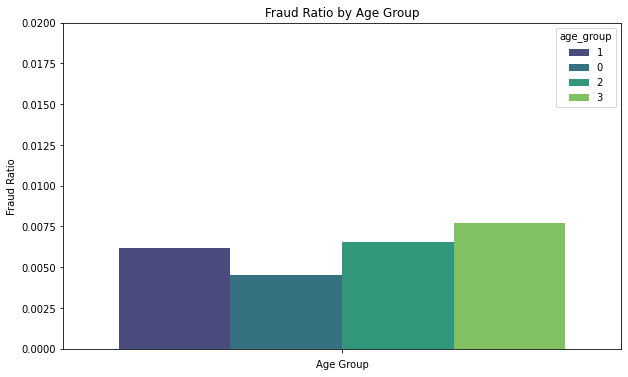

In [15]:
# Define age bins based on observed patterns
# another level on larger granular level would be 0-25, 25-50, 50+
bins = [0, 25, 45, 65, 100]
labels = ["Under 25", "25-45", "45-65", "65+"]
true_lables = [1, 0, 2, 3]  # 0 has the lowest fraud rate (risk), 1 has the highest
df["age_group"] = pd.cut(df["age"], bins=bins, labels=true_lables)

# Visualize the fraud ratio for each age group
age_group_fraud_ratio = df.groupby("age_group")["is_fraud"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=age_group_fraud_ratio, hue="age_group", y="is_fraud", palette="viridis"
)
plt.title("Fraud Ratio by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Fraud Ratio")
plt.ylim(0, 0.02)
plt.show()

### 2. Distiance Between Merchat and Card Holder

Geographical Discrepancies (Far Distance Between Cardholder and Merchant Address): When a cardholder's address and the merchant’s location are far apart, this could potentially signal that the transaction is fraudulent. This is particularly relevant for Card Not Present (CNP) fraud, where fraudsters often use stolen card details to make purchases in distant locations or countries. Or if the cardholder has typically made purchases in one region and suddenly makes a large purchase in a foreign country, it could indicate that the card details have been stolen and used without authorization.

In [ ]:
from data_visualisation.distance import calculate_distance
from geopy.distance import geodesic
def calculate_distance(row):
    cust_location = (row["lat"], row["long"])
    merch_location = (row["merch_lat"], row["merch_long"])
    return geodesic(cust_location, merch_location).miles
df["distance"] = df.apply(calculate_distance, axis=1)

In [125]:
def calculate_distance_over_average(df):
    # Calculate rolling average distance for the past 6 months
    df["avg_distance_6_months_1"] = df.sort_values(by=["trans_date_trans_time"]).groupby("cc_num").apply(
        lambda x: x.rolling('180D', on='trans_date_trans_time')["distance"].mean().shift(1)
    ).reset_index(0, drop=True)

    # Calculate average distance per city
    avg_distance_per_city = df.groupby("city")["distance"].mean()

    # Fill NaN values in 'avg_distance_6_months' with city average
    df["avg_distance_6_months"] = df.apply(
        lambda row: avg_distance_per_city[row["city"]] if pd.isna(row["avg_distance_6_months_1"]) else row["avg_distance_6_months_1"],
        axis=1
    )

    # Calculate distance over average distance
    df["distance_over_avg_1"] = df["distance"] / df["avg_distance_6_months"]

    return df


df = calculate_distance_over_average(df)

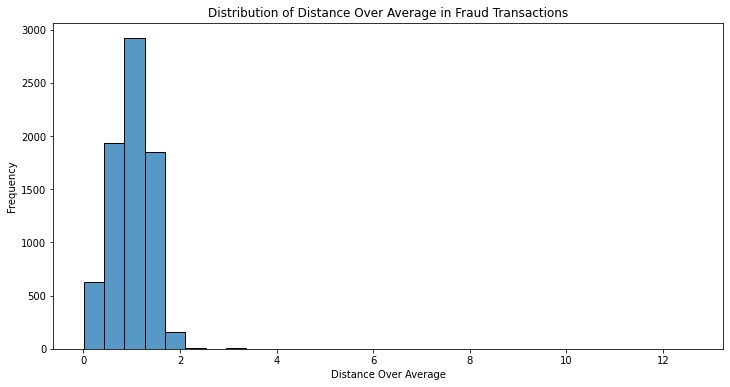

In [139]:
# Filter the dataframe for fraud transactions
fraud_transactions = df[df["is_fraud"] == 1]

# Plot the amt_over_avg for fraud transactions
plt.figure(figsize=(12, 6))
sns.histplot(fraud_transactions["distance_over_avg_1"], bins=30, kde=False, palette="tempo")
plt.title("Distribution of Distance Over Average in Fraud Transactions")
plt.xlabel("Distance Over Average")
plt.ylabel("Frequency")
plt.show()

NameError: name 'test' is not defined

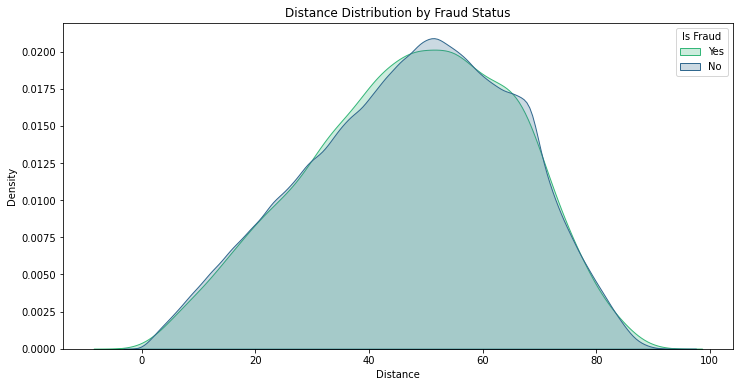

In [61]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="distance", hue="is_fraud", common_norm=False, fill=True, palette="viridis")
plt.title("Distance Distribution by Fraud Status")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.legend(title="Is Fraud", labels=["Yes", "No"])
plt.show()

### 3. Transaction Time and Frequency

Late-Night or Off-Hours Transactions: Transactions made outside typical shopping hours, such as late at night or during weekends or holidays when fraud is less likely to be detected, may indicate that a fraud is taking place, particularly if they are not in line with the cardholder’s usual behavior. In Addition, multiple transactions in a short period (e.g., multiple small purchases in one hour) may also indicates a fraudster testing or running up charges on a stolen card.

In [175]:
import holidays

# Extracting hour, day of the week, and weekend indicator
df["transaction_hour"] = df["trans_date_trans_time"].dt.hour
df["transaction_day_of_week"] = df["trans_date_trans_time"].dt.dayofweek

# Create a list of U.S. public holidays
us_holidays = holidays.US()

# Flag transactions that occurred on a public holiday or weekends
df["is_holiday"] = df["trans_date_trans_time"].dt.date.apply(
    lambda x: 1 if x in us_holidays else 0
)
df["is_holiday"] = df["transaction_day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

In [176]:
# Transactions per credit card in the last 24 hours
df["trans_date"] = df["trans_date_trans_time"].dt.date
# Count transactions by cc_num and trans_date
df["daily_trans_count"] = df.groupby(["cc_num", "trans_date"])["trans_num"].transform(
    "count"
)

In [1]:
# Calculate the fraud transaction rate by holiday
fraud_rate_by_holiday = df.groupby("is_holiday")["is_fraud"].mean().reset_index()

# Plot the fraud transaction rate by holiday
plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_rate_by_holiday, x="is_holiday", y="is_fraud", palette="viridis")
plt.title("Fraud Transaction Rate by Holiday")
plt.xlabel("Is Holiday")
plt.ylabel("Fraud Transaction Rate")
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.ylim(0, fraud_rate_by_holiday["is_fraud"].max() * 1.1)
plt.show()

NameError: name 'df' is not defined

In [183]:
# Calculate the fraud transaction rate by day of the week
# fraud_rate_by_day = df.groupby("transaction_day_of_week")["is_fraud"].mean().reset_index()

# # Plot the fraud transaction rate by day of the week
# plt.figure(figsize=(12, 6))
# sns.barplot(data=fraud_rate_by_day, x="transaction_day_of_week", y="is_fraud", palette="viridis")
# plt.title("Fraud Transaction Rate by Day of the Week")
# plt.xlabel("Day of the Week")
# plt.ylabel("Fraud Transaction Rate")
# plt.xticks(ticks=fraud_rate_by_day["transaction_day_of_week"], labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
# plt.ylim(0, fraud_rate_by_day["is_fraud"].max() * 1.1)
# plt.show()

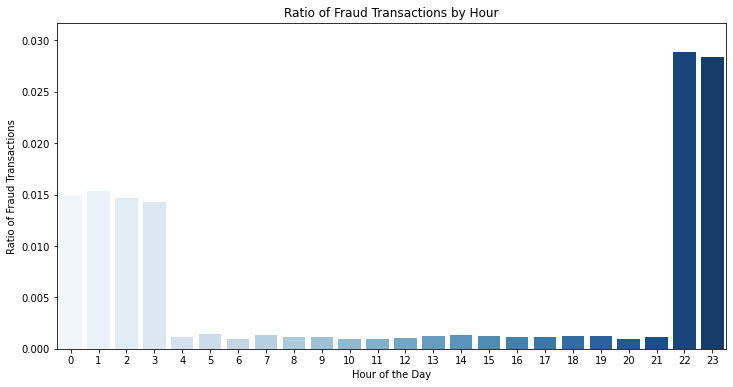

In [181]:
# Plot the ratio of fraud transactions by hour
fraud_ratio_by_hour = df.groupby("transaction_hour")["is_fraud"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=fraud_ratio_by_hour, x="transaction_hour", y="is_fraud", palette="Blues"
)
plt.title("Ratio of Fraud Transactions by Hour")
plt.xlabel("Hour of the Day")
plt.xticks(
    ticks=fraud_ratio_by_hour["transaction_hour"],
    labels=fraud_ratio_by_hour["transaction_hour"],
)
plt.ylabel("Ratio of Fraud Transactions")
plt.ylim(0, fraud_ratio_by_hour["is_fraud"].max() * 1.1)
plt.show()

In [178]:
df["is_high_risk_hour"] = df["transaction_hour"].apply(
    lambda x: 2 if x in [22, 23] else (1 if x in [0, 1, 2, 3] else 0)
)

### 4. Transaction Amount vs. Historical Averages

Fraudsters typically try to make the most out of the stolen card before the fraud is detected. Aside from making several purchases in quick period of time, the fraudsters also try to get high transactions suggesting that a high amount of transaction than average history spending habbit of the crad holder could be suspicious.

In [179]:
# Average transaction amount by credit card
df["avg_amt_by_card"] = df.groupby("cc_num")["amt"].transform("mean")
df["amt_over_avg"] = df["amt"] / df["avg_amt_by_card"]

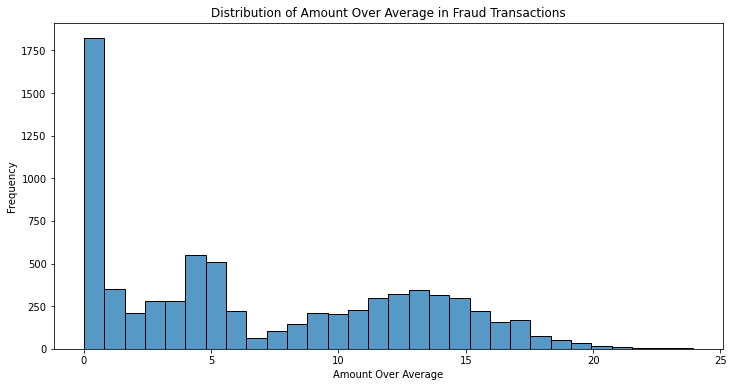

In [180]:
# Filter the dataframe for fraud transactions
fraud_transactions = df[df["is_fraud"] == 1]

# Plot the amt_over_avg for fraud transactions
plt.figure(figsize=(12, 6))
sns.histplot(fraud_transactions["amt_over_avg"], bins=30, kde=False, palette="tempo")
plt.title("Distribution of Amount Over Average in Fraud Transactions")
plt.xlabel("Amount Over Average")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()
# Set the plot size
plt.figure(figsize=(10, 8))

# Plot heatmap
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

### 5. City Size

**Major Cities:** Often considered to be populations over 500,000 or even 1 million. Some might even set the bar higher, considering only the very largest metropolitan areas like New York, Los Angeles, and Chicago as truly "big." Since the dataset dosen't contain much transaction history over cities with this much large of population, I took the margin at 150k.

**Mid-Sized Cities**: This is where there's a lot of variation. A common range is between 100,000 and 500,000. Some definitions might go as low as 50,000 or as high as approaching 1 million.

In [110]:
# Define the bins and labels for city size
city_size_bins = [0, df['city_pop'].quantile(0.85), df['city_pop'].quantile(0.99) ,float('inf')]
city_size_labels = ['Small', 'Medium', 'Large']
city_size_labels_true = [0,1,2]

# Create the city_size column
df['city_size'] = pd.cut(df['city_pop'], bins=city_size_bins, labels=city_size_labels_true)

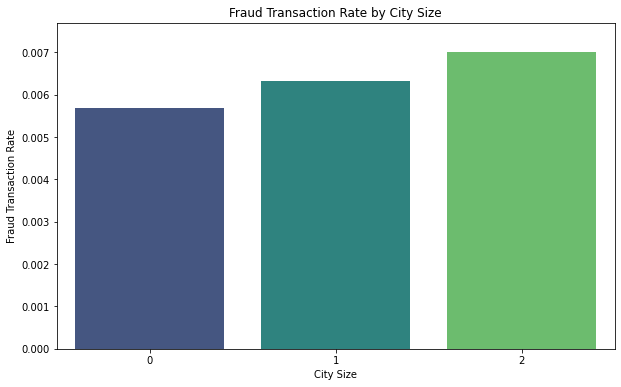

In [116]:
# Calculate the fraud transaction rate by city size
fraud_rate_by_city_size = df.groupby("city_size")["is_fraud"].mean().reset_index()

# Plot the fraud transaction rate by city size
plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_rate_by_city_size, x="city_size", y="is_fraud", palette="viridis")
plt.title("Fraud Transaction Rate by City Size")
plt.xlabel("City Size")
plt.ylabel("Fraud Transaction Rate")
plt.ylim(0, fraud_rate_by_city_size["is_fraud"].max() * 1.1)
plt.show()

In [ ]:
# a general overview of the dataset
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Unnamed: 0[int64],Mean (sd) : 648337.0 (374318.0)min < med < max:0.0 < 648337.0 < 1296674.0IQR (CV) : 648337.0 (1.7),"1,296,675 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAAsTAAALEwEAmpwYAAAA30lEQVR4nO3UMQoCMRBAURXLqbOFjRfxEJ5gzpYTeArvsY2FqdOvrQgLaVbB/1+ZDGHgQ/bLsuz0/w6/XkDfcVy7KKVcI2IaeaT3fo6I2dnx2Y33eLbWbu9nq6EjYsrMx8jDtdZLZt6dHZ/deI/T55lfN4ShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQxga4gWhg1ey46OS8wAAAABJRU5ErkJggg=="">",0(0.0%)
2,trans_date_trans_time[datetime64[ns]],Min: 2019-01-01Max: 2020-06-21Duration: 537 days,1274791 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAAA2CAYAAADJRMdfAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAAsTAAALEwEAmpwYAAABUklEQVR4nO3YsW2EMBhAYSeKROO0XJGOBZIFMkQmoL21mCBTpQg1DRISadIdEuZIjB96X03xSw9s7Id5noOYHo8eQPd7OnqAUtR1/RFjvKw9NwzDd9/3nzlmWmO8XzHGS9u2X2vPdV33kmOeFC6bYMYDMx6Y8cCMB2Y8MOOBGQ/MeGDF3bAQr6mOUlw84jXVUYqLl2ocx7emaa5rz535C8XGq6rq+QxfaOo2EcLti5gl3pYBp2l6DSGsRjmL1G0ihNsXMUu8jQO+//c8Z4FdNkuXutrsWWl2xcsx4F6pPzZ/PeOGv+a7V5pd8XIMuNeGHxvccu0NC5jxwIwHZjww44EZD8xD+kZHnRuXLMYjHL6PUtK5cTEe4fAt9zw044EZD8x4YMYDMx6Y8cCMB2Y8MOOBGQ/MeGDGAzMemPHAjAdmPDDjgRkPzHhgxgMzHpjxwH4AkhR0qZVeZeMAAAAASUVORK5CYII="">",0(0.0%)
3,cc_num[int64],Mean (sd) : 417192042079726656.0 (1308806447000240384.0)min < med < max:60416207185.0 < 3521417320836166.0 < 4992346398065154048.0IQR (CV) : 4462212528794792.0 (0.3),983 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHoAAAAyCAYAAACTUs/lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAAsTAAALEwEAmpwYAAAA7klEQVR4nO3csQ3CMBQAUUAUKVwnBUMwAUMwgWfzBHRsRIFr92EBLCWKwYi719pyvnRSyr+f53mn/3foPYC+41g7GMfxGkKYljxSSnnmnG/txlJr1dAhhCnG+FjySErp1G4kfYK/bghDQxgawtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBrC0BCGhjA0hKEhDA1haAhDQxgawtAQhoYwNIShIQwNYWgIQ0MYGsLQEIaGMDSEoSEMDWFoCENDGBqiugtUv2XrEl5Dd7Qm3jAM5xjjfcndd0t4Dd3Ryg3Kly3fegGR2yDpZf4wjAAAAABJRU5ErkJggg=="">",0(0.0%)
4,merchant[object],"1. fraud_Kilback LLC2. fraud_Cormier LLC3. fraud_Schumm PLC4. fraud_Kuhn LLC5. fraud_Boyer PLC6. fraud_Dickinson Ltd7. fraud_Cummerata-Jones8. fraud_Kutch LLC9. fraud_Olson, Becker and Koch10. fraud_Stroman, Hudson and Erdm11. other","4,403 (0.3%)3,649 (0.3%)3,634 (0.3%)3,510 (0.3%)3,493 (0.3%)3,434 (0.3%)2,736 (0.2%)2,734 (0.2%)2,723 (0.2%)2,721 (0.2%)1,263,638 (97.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAG8AAACzCAYAAACHOUI0AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAAsTAAALEwEAmpwYAAACIUlEQVR4nO3aoW3DUBhG0Wer0DQKKG/n6QSeLRN0n/KAGpu7qDwysa50zgRPutIP/Hk6jmPQNF/9AM4TL0y8MPHCxAsTL0y8sHmaps+rH8E58xjj4+pHcI6zGSZemHhh4oWJFyZemHhh4oWJFyZe2DzG+Ln6EZwz+QGpy9kMMwmFmYTCnM0w8cLECxMvTLww8cLECxMvTLww8cJMQmEmoTBnM8wkFGYSCnM2w8QLEy9MvDDxwsQLEy9MvDDxwsQLMwmFmYTCnM0wk1CYSSjM2QwTL0y8MPHCxAsTL0y8MPHCxAsTL8wkFGYSCnM2w0xCYSahMGczTLww8cLECxMvTLww8cLECxMvTLwwk1CYSSjM2QwzCYWZhMKczTDxwsQLEy9MvDDxwsQLEy9MvDDxwkxCYSahMGczzCQUZhIKczbDxAsTL0y8MPHCxAsTL0y8MPHCxAszCYWZhMKczTCTUJhJKMzZDBMvTLww8cLECxMvTLww8cLECxMvTLwwe16YPS/M2Qyz54XZ88KczTDxwsQLEy9MvDDxwsQLEy9MvDDxwkxCYSahMGczzCQUZhIKczbDxAsTL0y8MPHCxAsTL0y8MPHCxAszCYWZhMKczbDpdrt9Lctyv/ohvG7f999t277flmW5r+v6vPpBvO7xeLyP4WymiRcmXph4YeKFiRcmXph4YeKFiRfm22bQ/7dNk1CYsxkmXph4YeKFiRcmXtgfhqxFEDsGQrkAAAAASUVORK5CYII="">",0(0.0%)
5,category[object],1. gas_transport2. grocery_pos3. home4. shopping_pos5. kids_pets6. shopping_net7. entertainment8. food_dining9. personal_care10. health_fitness11. other,"131,659 (10.2%)123,638 (9.5%)123,115 (9.5%)116,672 (9.0%)113,035 (8.7%)97,543 (7.5%)94,014 (7.3%)91,461 (7.1%)90,758 (7.0%)85

## Data Preperation

select features and then split data into train and validation. The features I selected are: 
amt, 

### Target Imbalance